In [1]:
# Install DeepChem
!pip install deepchem
!pip install rdkit
!pip install --upgrade deepchem



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.4/552.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 36.9 MB/s eta 0:00:00


# Load and import dataset

In [3]:
!wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv


--2025-09-02 04:50:19--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.193.42, 52.219.194.122, 16.15.4.101, ...
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.193.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/csv]
Saving to: ‘delaney-processed.csv’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.04s   

2025-09-02 04:50:19 (2.11 MB/s) - ‘delaney-processed.csv’ saved [96699/96699]



In [4]:
!pip install rdkit

import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

# Load ESOL dataset
df = pd.read_csv("delaney-processed.csv")

# Function to featurize molecules into Morgan fingerprints
def featurize_smiles(smiles, radius=2, n_bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    else:
        return None

# Apply featurization
fingerprints = [featurize_smiles(s) for s in df["smiles"]]
X = np.array([np.array(fp) for fp in fingerprints if fp is not None])
y = df["measured log solubility in mols per litre"].values

print("Fingerprint shape:", X.shape)
print("Target shape:", y.shape)
from rdkit.Chem import Descriptors

def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return [
            Descriptors.MolWt(mol),        # Molecular weight
            Descriptors.MolLogP(mol),      # LogP (hydrophobicity)
            Descriptors.NumHDonors(mol),   # H-bond donors
            Descriptors.NumHAcceptors(mol),# H-bond acceptors
            Descriptors.TPSA(mol),         # Polar surface area
            Descriptors.NumRotatableBonds(mol) # Flexibility
        ]
    else:
        return [None] * 6

# Apply to dataset
extra_features = np.array([calculate_descriptors(s) for s in df["smiles"]])

# Combine with fingerprints
X = np.hstack([X, extra_features])



[04:50:30] DEPRECATION WARNING: please use MorganGenerator
[04:50:30] DEPRECATION WARNING: please use MorganGenerator
[04:50:30] DEPRECATION WARNING: please use MorganGenerator
[04:50:30] DEPRECATION WARNING: please use MorganGenerator
[04:50:30] DEPRECATION WARNING: please use MorganGenerator
[04:50:30] DEPRECATION WARNING: please use MorganGenerator
[04:50:30] DEPRECATION WARNING: please use MorganGenerator
[04:50:30] DEPRECATION WARNING: please use MorganGenerator
[04:50:30] DEPRECATION WARNING: please use MorganGenerator
[04:50:30] DEPRECATION WARNING: please use MorganGenerator
[04:50:30] DEPRECATION WARNING: please use MorganGenerator
[04:50:30] DEPRECATION WARNING: please use MorganGenerator
[04:50:30] DEPRECATION WARNING: please use MorganGenerator
[04:50:30] DEPRECATION WARNING: please use MorganGenerator
[04:50:30] DEPRECATION WARNING: please use MorganGenerator
[04:50:30] DEPRECATION WARNING: please use MorganGenerator
[04:50:30] DEPRECATION WARNING: please use MorganGenerat

Fingerprint shape: (1128, 1024)
Target shape: (1128,)


# Data splitting

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Baseline Model - Linear Regression

In [6]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

# Predictions and Metrics

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = lr.predict(X_test)

In [8]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


In [9]:

print("Baseline: Linear Regression")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R²: {r2:.3f}")
print(f"MSE: {mse:.3f}")

Baseline: Linear Regression
RMSE: 4.420
MAE: 3.017
R²: -3.134
MSE: 19.539


# Predicted vs Actual solubility



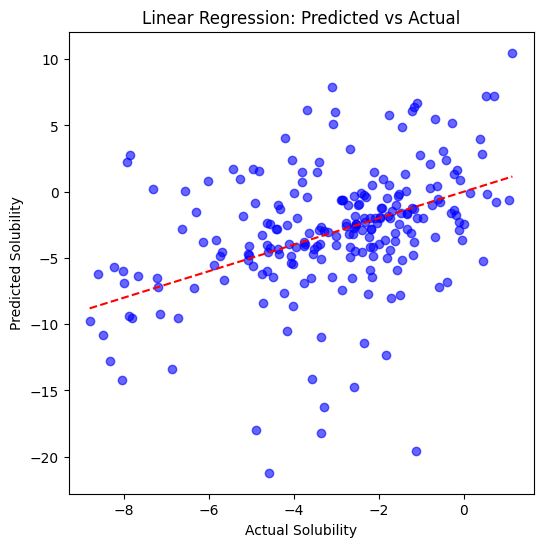

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel("Actual Solubility")
plt.ylabel("Predicted Solubility")
plt.title("Linear Regression: Predicted vs Actual")
plt.show()


# Non linear model - Random forest regressor

In [11]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

# Prediction

In [12]:
y_pred_rf = rf.predict(X_test)

# Evaluate

In [13]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest MSE:", mse_rf)
print("Random Forest R²:", r2_rf)

Random Forest MSE: 0.6320074920273338
Random Forest R²: 0.8662928354366547


# Predicted vs Actual solubility

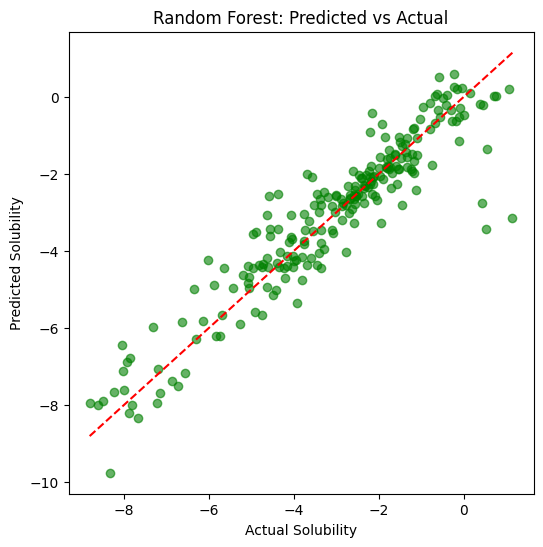

In [14]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Solubility")
plt.ylabel("Predicted Solubility")
plt.title("Random Forest: Predicted vs Actual")
plt.show()


# Train XGBoost

In [15]:
from xgboost import XGBRegressor


xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

# Predictions

In [16]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred_xgb = xgb.predict(X_test)


# Metrics

In [17]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost MSE:", mse_xgb)
print("XGBoost R²:", r2_xgb)

XGBoost MSE: 0.4780555085710589
XGBoost R²: 0.8988628341257704


# Plot (XGBoost)

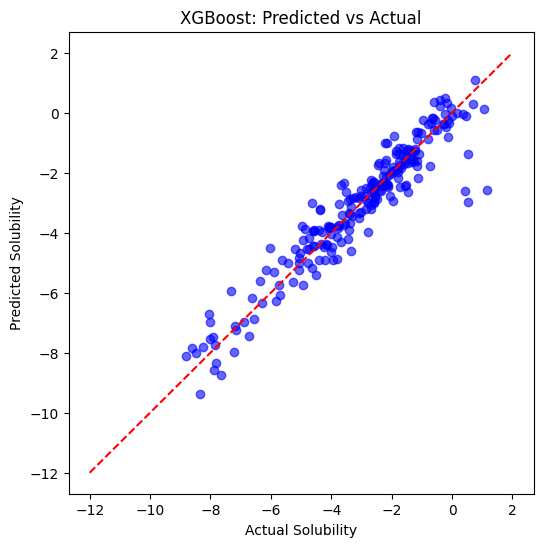

In [18]:
import matplotlib.pyplot as plt


# Scatter plot: Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.6, color="blue")
plt.plot([-12, 2], [-12, 2], 'r--')  # ideal line
plt.xlabel("Actual Solubility")
plt.ylabel("Predicted Solubility")
plt.title("XGBoost: Predicted vs Actual")
plt.show()


# Model Comparison-

                      MSE     R²
Linear Regression  19.539 -3.134
Random Forest       0.632  0.866
XGBoost             0.478  0.898


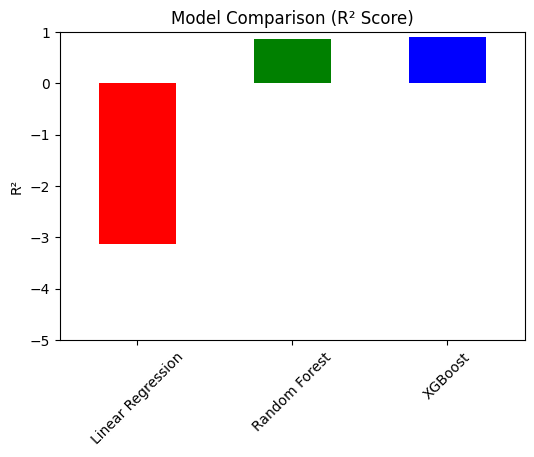

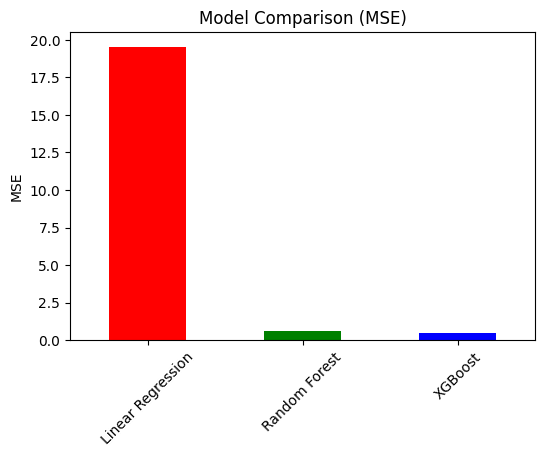

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Collect results
results = {
    "Linear Regression": {"MSE": 19.539, "R²": -3.134},   # use your actual LR values
    "Random Forest": {"MSE": 0.632, "R²": 0.866},
    "XGBoost": {"MSE": 0.478, "R²": 0.898}
}

# Convert to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

# --- Bar Plot for R² ---
plt.figure(figsize=(6,4))
results_df["R²"].plot(kind="bar", color=["red", "green", "blue"])
plt.title("Model Comparison (R² Score)")
plt.ylabel("R²")
plt.xticks(rotation=45)
plt.ylim(-5, 1)  # adjust to see Linear Regression's negative value
plt.show()

# --- Bar Plot for MSE ---
plt.figure(figsize=(6,4))
results_df["MSE"].plot(kind="bar", color=["red", "green", "blue"])
plt.title("Model Comparison (MSE)")
plt.ylabel("MSE")
plt.xticks(rotation=45)
plt.show()


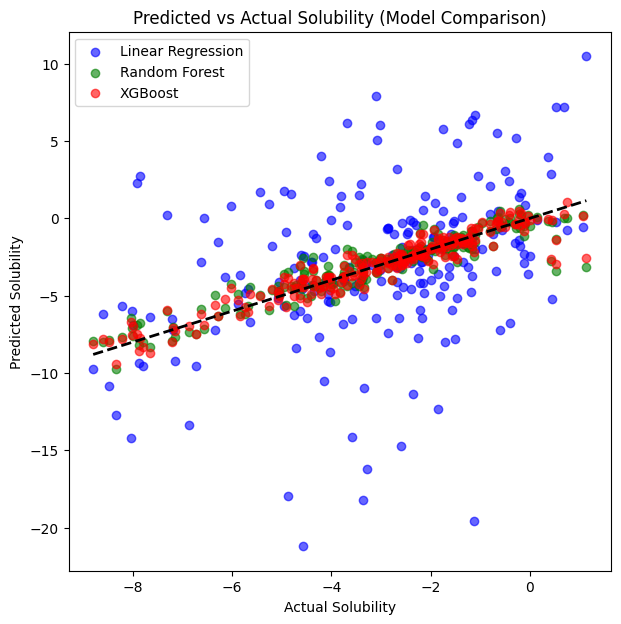

In [20]:
import matplotlib.pyplot as plt
y_pred_xgb = xgb.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred = lr.predict(X_test)
# Scatter plot comparison
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.6, label="Linear Regression", color="blue")
plt.scatter(y_test, y_pred_rf, alpha=0.6, label="Random Forest", color="green")
plt.scatter(y_test, y_pred_xgb, alpha=0.6, label="XGBoost", color="red")

# Reference line (perfect prediction)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.xlabel("Actual Solubility")
plt.ylabel("Predicted Solubility")
plt.title("Predicted vs Actual Solubility (Model Comparison)")
plt.legend()
plt.show()


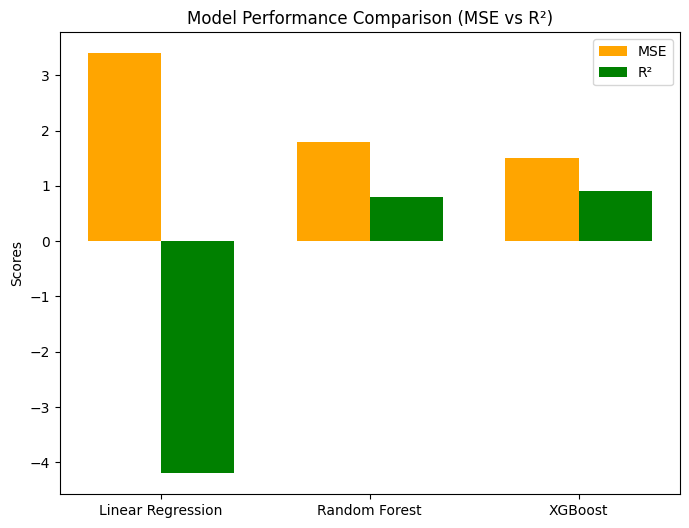

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Example values (replace with your actual results)
models = ['Linear Regression', 'Random Forest', 'XGBoost']
mse_values = [3.4, 1.8, 1.5]   # Replace with your MSE values
r2_values = [-4.2, 0.8, 0.9]   # Replace with your R² values

x = np.arange(len(models))  # model positions
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(8, 6))

# Bars
rects1 = ax.bar(x - width/2, mse_values, width, label='MSE', color='orange')
rects2 = ax.bar(x + width/2, r2_values, width, label='R²', color='green')

# Labels & title
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison (MSE vs R²)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()



# Hyperparameter Tuning for XGBoost

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

params = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)
search = RandomizedSearchCV(xgb, params, n_iter=20, scoring="r2", cv=5, n_jobs=-1, verbose=2)
search.fit(X, y)

print("Best R2:", search.best_score_)
print("Best params:", search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best R2: 0.9104771117617194
Best params: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


# Final XGBoost Model with Best Parameters

In [24]:
# --- Final XGBoost with best params from RandomizedSearchCV ---
best_params = {
    'subsample': 0.6,
    'n_estimators': 500,
    'max_depth': 10,
    'learning_rate': 0.01,
    'colsample_bytree': 0.8
}

xgb_final = XGBRegressor(**best_params, random_state=42)
xgb_final.fit(X_train, y_train)

# Predictions
y_pred_xgb_final = xgb_final.predict(X_test)

# Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2 = r2_score(y_test, y_pred_xgb_final)
mae = mean_absolute_error(y_test, y_pred_xgb_final)
mse = mean_squared_error(y_test, y_pred_xgb_final)

print("Final XGBoost Performance (Tuned):")
print("R²:", r2)
print("MAE:", mae)
print("MSE:", mse)


Final XGBoost Performance (Tuned):
R²: 0.8862377807595195
MAE: 0.5027353200920387
MSE: 0.5377316548776035


# Baseline vs Tuned XGBoost Performance

In [26]:
# Baseline XGBoost
xgb_base = XGBRegressor(random_state=42)
xgb_base.fit(X_train, y_train)
y_pred_base = xgb_base.predict(X_test)

r2_base = r2_score(y_test, y_pred_base)
mae_base = mean_absolute_error(y_test, y_pred_base)
mse_base = mean_squared_error(y_test, y_pred_base)

# Tuned XGBoost (already trained as xgb_final)
r2_tuned = r2_score(y_test, y_pred_xgb_final)
mae_tuned = mean_absolute_error(y_test, y_pred_xgb_final)
mse_tuned = mean_squared_error(y_test, y_pred_xgb_final)

# Print comparison
print("Baseline XGBoost - R2:", r2_base, " MAE:", mae_base, " MSE:", mse_base)
print("Tuned XGBoost    - R2:", r2_tuned, " MAE:", mae_tuned, " MSE:", mse_tuned)


Baseline XGBoost - R2: 0.8814127660910936  MAE: 0.5150823282522965  MSE: 0.5605385510491417
Tuned XGBoost    - R2: 0.8862377807595195  MAE: 0.5027353200920387  MSE: 0.5377316548776035


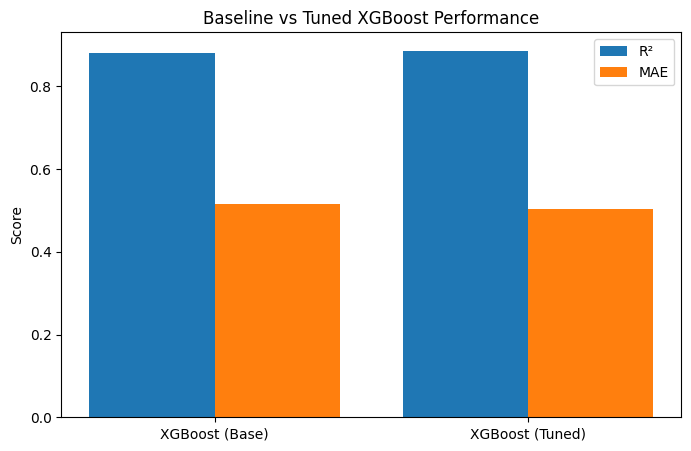

In [27]:
import matplotlib.pyplot as plt
import numpy as np

models = ["XGBoost (Base)", "XGBoost (Tuned)"]
r2_scores = [r2_base, r2_tuned]
mae_scores = [mae_base, mae_tuned]

x = np.arange(len(models))

plt.figure(figsize=(8,5))
plt.bar(x - 0.2, r2_scores, width=0.4, label="R²")
plt.bar(x + 0.2, mae_scores, width=0.4, label="MAE")
plt.xticks(x, models)
plt.ylabel("Score")
plt.title("Baseline vs Tuned XGBoost Performance")
plt.legend()
plt.show()


# Predicted vs Actual (two plots)

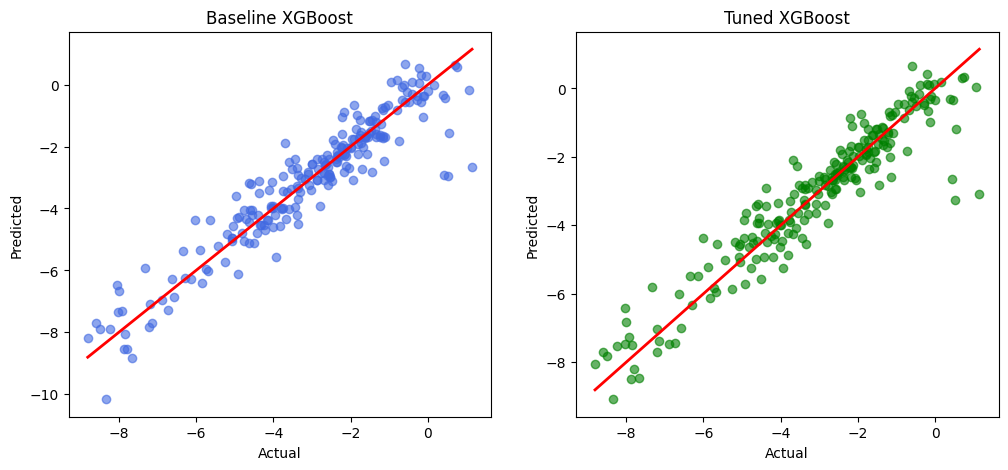

In [28]:
plt.figure(figsize=(12,5))

# Baseline
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_base, alpha=0.6, color="royalblue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Baseline XGBoost")

# Tuned
plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_xgb_final, alpha=0.6, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Tuned XGBoost")

plt.show()
